In [51]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset, ELM, device
torch.set_default_dtype(torch.float64)

In [52]:
x_data = np.float64(np.linspace(-15, 15, 500))
y_data = np.float64(np.sin(x_data) / x_data)

In [53]:
dataset = Dataset(x_data, y_data)
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

activation = nn.Sigmoid()

In [54]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

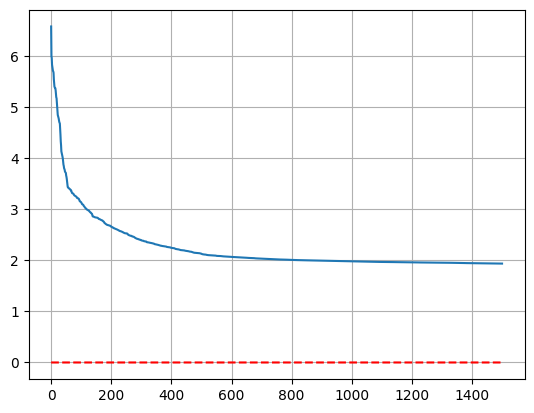

In [55]:
Lmax, epsilon = 1500, 1e-7
E, L = trainset[:][1], 0
k = 5 # 1 dla I-ELM, > 1 dla EI-ELM
temp_model = ELM(1, Lmax, 1)
Error = [torch.norm(E)]

while L < Lmax and torch.norm(E) > epsilon:
    L += 1
    Enorm = torch.norm(E)
    for i in range(k):
        W1 = torch.randn(2, 1)
        h = activation(W1[0].reshape(-1, 1) + W1[1] @ trainset[:][0].reshape(1, -1))
        beta = torch.div(E.reshape(1, -1) @ h.T, h @ h.T)
        if Enorm > torch.norm(E - beta @ h):
            h_star = h
            W1_star = W1
            beta_star = beta
            Enorm = torch.norm(E - beta @ h)
    E = E - beta_star @ h_star
    Error.append(torch.norm(E))
    temp_model.fc1.bias.data[L-1], temp_model.fc1.weight.data[L-1], temp_model.fc2.weight.data[:,L-1] = W1_star[0], W1_star[1], beta_star

plt.plot(Error)
plt.plot([epsilon]*len(Error), 'r--')
plt.grid()
plt.show()

In [56]:
model = ELM(1, L, 1)

model.fc1.bias.data, model.fc1.weight.data, model.fc2.weight.data = \
temp_model.fc1.bias.data[:L], temp_model.fc1.weight.data[:L], temp_model.fc2.weight.data[:L]

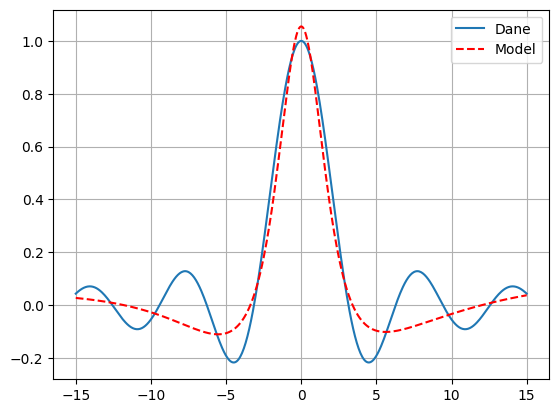

Train error: 0.008994563277279079
Test error: 0.010556105887355867


In [57]:
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1)).detach().numpy(), 'r--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.grid()
plt.show()
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 1))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 1))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')

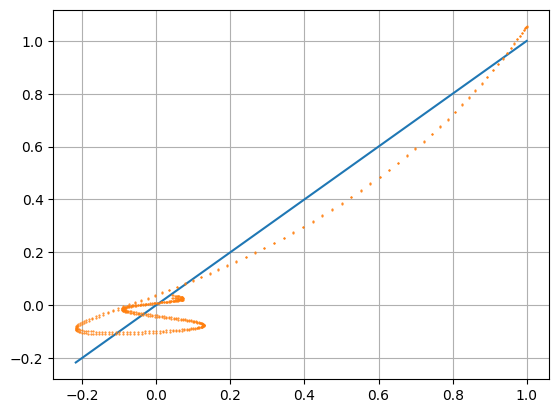

In [58]:
plt.plot([np.min(y_data), np.max(y_data)], [np.min(y_data), np.max(y_data)])
plt.plot(y_data, model(torch.tensor(x_data).reshape(-1, 1)).detach().numpy(), '.', markersize=1)
plt.grid()
plt.show()